In [17]:
import xarray as xr
import datetime as dt
import netCDF4
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [87]:
sns.set_theme()

In [2]:
from ristretto.svd import compute_rsvd

In [5]:
current_date = dt.datetime(2019, 1, 1)
end_date = dt.datetime(2019, 1, 10)
increment = dt.timedelta(days=1)
arr = None

In [8]:
while current_date < end_date:
    print("working on", current_date)
    data = xr.open_dataset(r"D:atmo-chem/data/NO2_" + str(current_date)[:10] + ".nc4")
    darr = data.to_array()
    if arr is None:
        arr = darr[0, :, 0, :, :]
    else:
        arr = xr.concat([arr, darr[0, :, 0, :, :]], dim="time")
    del darr
    next_date = current_date + increment
    current_date = next_date

working on 2019-01-01 00:00:00
working on 2019-01-02 00:00:00
working on 2019-01-03 00:00:00
working on 2019-01-04 00:00:00
working on 2019-01-05 00:00:00
working on 2019-01-06 00:00:00
working on 2019-01-07 00:00:00
working on 2019-01-08 00:00:00
working on 2019-01-09 00:00:00


In [22]:
plt.imshow?

<IPython.core.display.Javascript object>


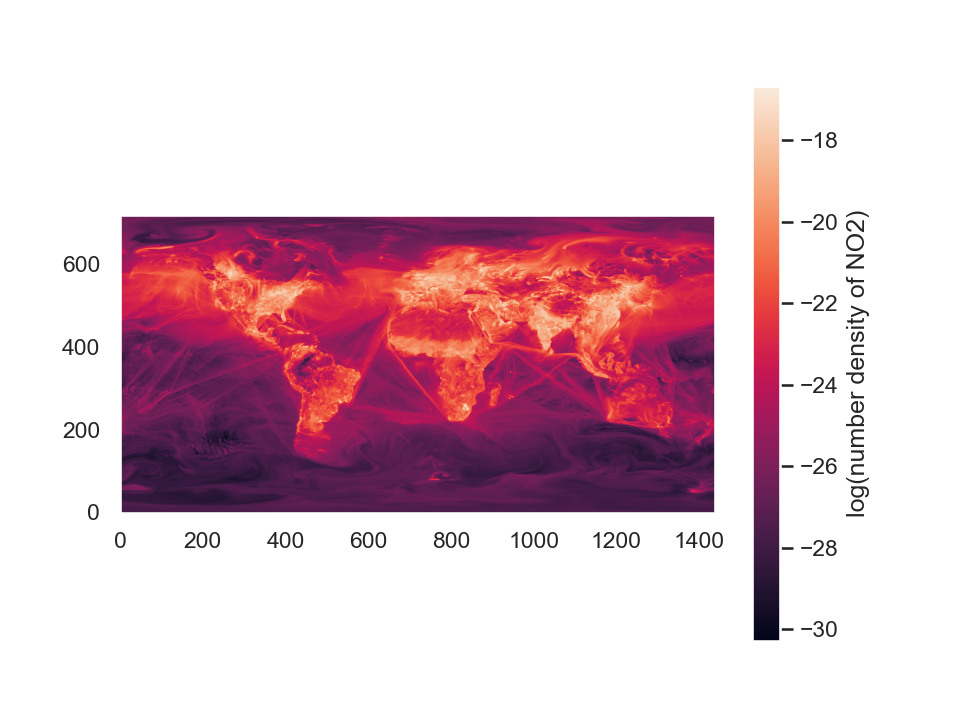

In [39]:
# fig, ax = plt.subplots(1, 1, figsize=(12, 12))
%matplotlib notebook
plt.figure(dpi=200)
plt.grid()
plt.imshow(np.log(arr[0, :, :]), origin="lower")
plt.colorbar(label="log(number density of NO2)")
plt.show()

In [41]:
plt.savefig("2019Jan1_map.png")

In [46]:
nparr = np.log(arr.to_numpy() + 1e-30)
A = nparr.reshape([nparr.shape[0], nparr.shape[1] * nparr.shape[2]]).T
A.shape

(1038240, 216)

In [42]:
compute_rsvd?

### Matrix Energy

In [77]:
rank = 100
U, s, Vt = compute_rsvd(A, rank, random_state=633)

In [78]:
A.shape

(1038240, 216)

In [84]:
min_s = s[-1]
# basically I'm assuming all the unkown singular values are as large as possible
total_energy_upper_bound = sum(s) + (A.shape[1] - rank) * min_s

In [85]:
energies = []
for r in range(rank):  # try smaller rank decompositions
    energies.append(sum(s[:r + 1]) * 100 / total_energy_upper_bound)

<IPython.core.display.Javascript object>


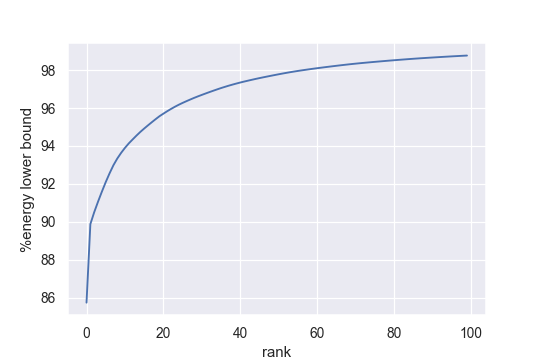

In [138]:
%matplotlib notebook
plt.figure(dpi=120)
plt.plot(energies)
plt.xlabel("rank")
plt.ylabel("%energy lower bound")
plt.show()

In [139]:
plt.savefig("9day_energy_plot.png")

In [58]:
U.shape

(1038240, 30)

In [83]:
U_ims = U.reshape((nparr.shape[1], nparr.shape[2], U.shape[1]))

In [108]:
U_ims[:, :, 0] / U_ims[:, :, 1]

array([[0.99223256, 0.9925369 , 0.9924788 , ..., 0.9924788 , 0.9924788 ,
        0.9924788 ],
       [0.9835084 , 0.9835153 , 0.983522  , ..., 0.9835004 , 0.9835135 ,
        0.9835148 ],
       [0.974563  , 0.9745851 , 0.97459865, ..., 0.974517  , 0.974519  ,
        0.9745288 ],
       ...,
       [1.1738155 , 1.1735897 , 1.1732826 , ..., 1.1746228 , 1.174326  ,
        1.1740878 ],
       [1.2684441 , 1.268243  , 1.2680482 , ..., 1.2690634 , 1.2688599 ,
        1.2686226 ],
       [2.0089023 , 2.0089023 , 2.0089023 , ..., 2.008907  , 2.0089023 ,
        2.0089023 ]], dtype=float32)

In [128]:
np.sum(U_ims[:, :, 1] ** 2)

1.0000001

<IPython.core.display.Javascript object>


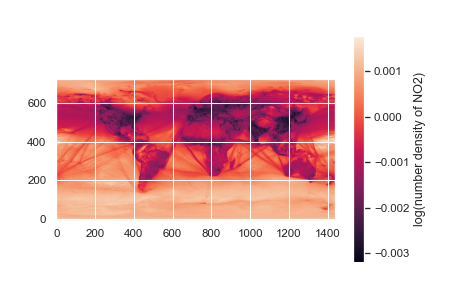

In [137]:
spatial_mode = 10
plt.figure(dpi=100)
plt.imshow(U_ims[:, :, 1], origin="lower")
plt.colorbar(label="log(number density of NO2)")
plt.show()

<IPython.core.display.Javascript object>


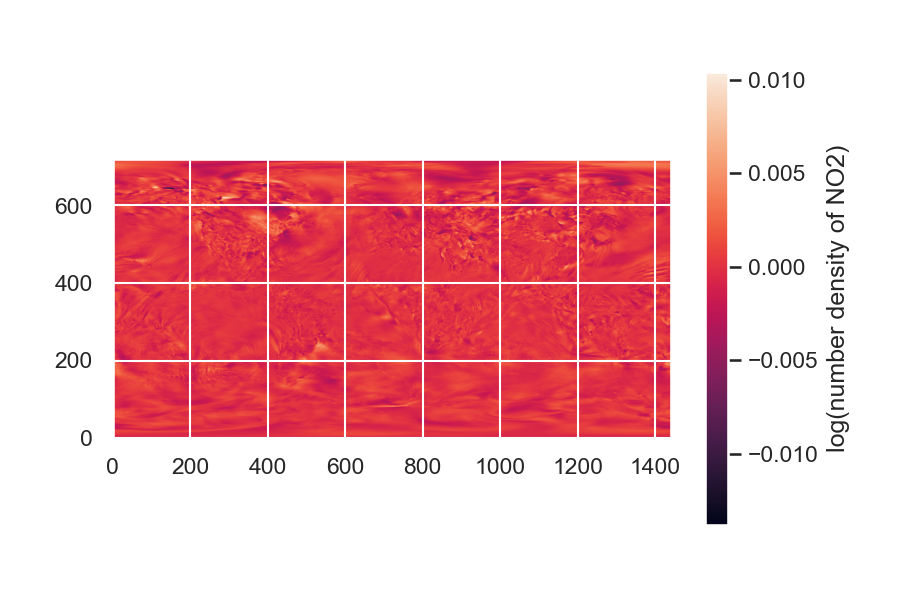

In [122]:
spatial_mode = 10
plt.figure(dpi=200)
plt.imshow(U_ims[:, :, spatial_mode - 1], origin="lower")
plt.colorbar(label="log(number density of NO2)")
plt.show()

In [118]:
plt.savefig(f"2019Jan1-Jan9_spatial_mode{spatial_mode}.png")

In [129]:
from scipy.linalg import svd as sp_svd

In [130]:
sp_U, sp_s, sp_Vt = sp_svd(A, full_matrices=False)

In [131]:
sp_U_ims = U_ims.reshape((nparr.shape[1], nparr.shape[2], U.shape[1]))

<IPython.core.display.Javascript object>


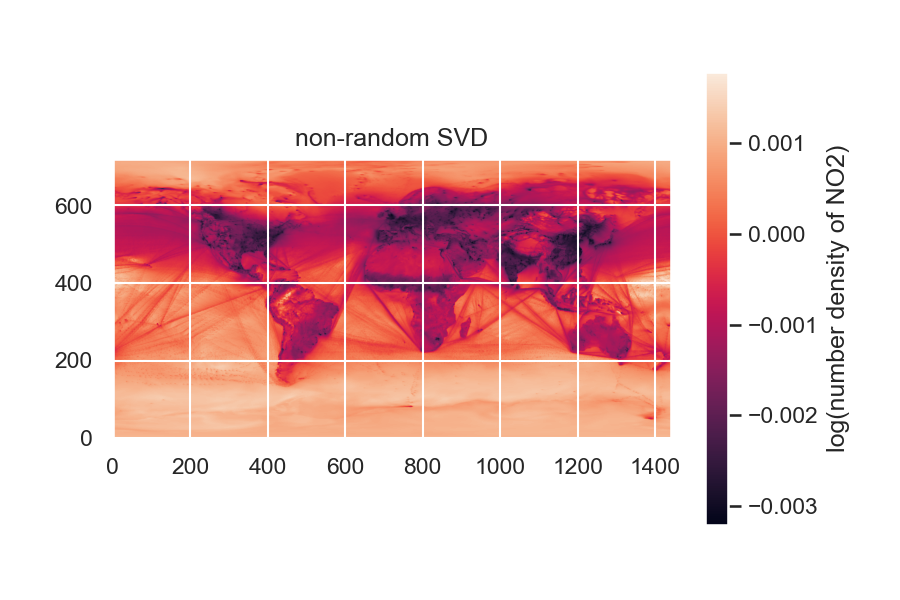

In [134]:
spatial_mode = 2
plt.figure(dpi=200)
plt.imshow(sp_U_ims[:, :, spatial_mode - 1], origin="lower")
plt.colorbar(label="log(number density of NO2)")
plt.title("non-random SVD")
plt.show()

In [135]:
plt.savefig(f"2019Jan1-Jan9_nonrandom_spatial_mode{spatial_mode}.png")

In [140]:
s

array([4.94621250e+05, 2.38588105e+04, 3.61625000e+03, 3.21157690e+03,
       3.04056909e+03, 2.89680664e+03, 2.66839429e+03, 2.45509912e+03,
       2.02628113e+03, 1.71976599e+03, 1.52443701e+03, 1.36517639e+03,
       1.19573145e+03, 1.17323022e+03, 1.11059595e+03, 1.02535022e+03,
       9.81139771e+02, 9.52965332e+02, 9.30191284e+02, 8.96529053e+02,
       7.62806152e+02, 7.45296326e+02, 6.95285767e+02, 6.58357544e+02,
       6.08493713e+02, 5.57950439e+02, 5.26163452e+02, 5.08060455e+02,
       4.94089783e+02, 4.61257660e+02, 4.44268097e+02, 4.34044403e+02,
       4.25629852e+02, 4.14532471e+02, 4.05436981e+02, 3.95850525e+02,
       3.65196777e+02, 3.58141510e+02, 3.34327850e+02, 3.19255615e+02,
       3.04475250e+02, 2.88886993e+02, 2.72685455e+02, 2.69165192e+02,
       2.63207031e+02, 2.50466537e+02, 2.41655640e+02, 2.35348419e+02,
       2.33199631e+02, 2.29405579e+02, 2.24299255e+02, 2.21266144e+02,
       2.09194092e+02, 2.05141479e+02, 1.91650299e+02, 1.84514648e+02,
      